In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
  !git config --global user.email "naiaseh@uwo.com"
  !git config --global user.name "Nadia Aiaseh"

In [2]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [ ]:
from modules.models import KPPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import imageio

In [ ]:

phi = 0



def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])




In [ ]:
angle = np.pi/180. * 60.
ampl = 1.5
one = (np.tan(angle) - np.sqrt(2*ampl))/2
two = one + np.sqrt(2*ampl)
k1 = np.min([one, two])
k2 = np.max([one, two])
print(k1, k2)

-2.220446049250313e-16 1.732050807568877


In [ ]:


def phi_function1(txy):
    c = 3.
    angle_y_axis = (30.*np.pi/180)
    offset =  20.
    lamb = tf.tan(angle_y_axis)
    kappa = tf.sqrt(c/4)
    ksi = txy[:, 1:2] + lamb*txy[:,2:3] - (c+3*lamb**2) * txy[:,0:1] + offset
    u = c / (2*tf.cosh(kappa*(ksi))**2)+phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u



x_start =  -20.
length = 20.
y_start = x_start
ylength = length
t0 = 0.
time = 10.




(300, 3)
my shape tf.Tensor([90000     1], shape=(2,), dtype=int32) tf.Tensor([300 300], shape=(2,), dtype=int32)


Text(0.5, 1.0, 'wave cross section at y = 0')

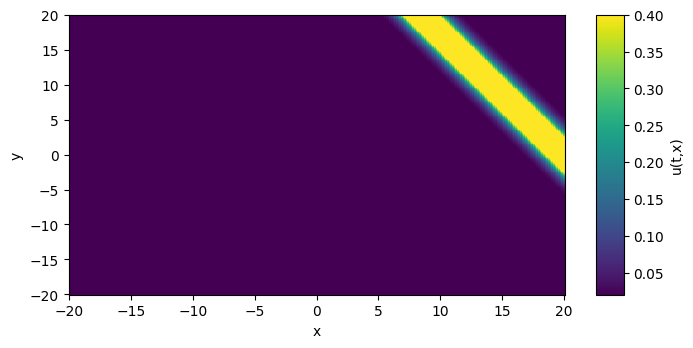

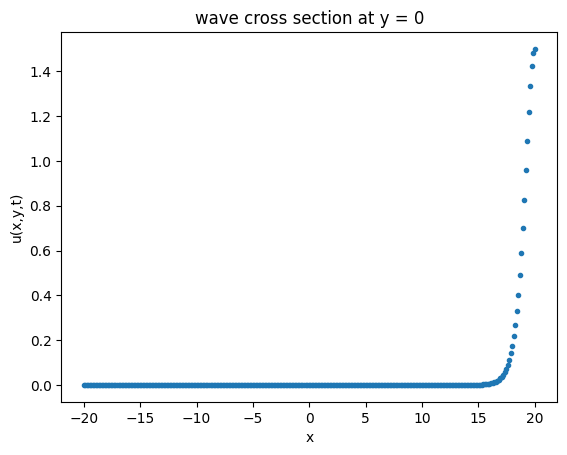

In [ ]:
from matplotlib.gridspec import GridSpec
N = 300
TIME = 10.
xt = np.linspace(x_start,length,N).T
yt = np.linspace(y_start,ylength,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])

x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)
fig = plt.figure(figsize=(8,8))

gs = GridSpec(2, 5)
plt.subplot(gs[0, :])

ut = phi_function1(txy)
print('my shape',tf.shape(ut), tf.shape(x))
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
# cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
cbar.mappable.set_clim( 0.02, 0.4)
fig = plt.figure()

cross_sect = 0

txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function1(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, '.',label = 'exact at time {}'.format(0))

plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))

In [ ]:
# when boundary function is set to None, the data will be collected from the phi_function but at boundary
(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = simulate_KP(50000, phi_function1, None, time, x_start, length, y_start, ylength, n_bnds = None,\
                                                                                                                                                               n_init = None, tstart = t0, random_seed = 42, dtype=tf.float32)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)



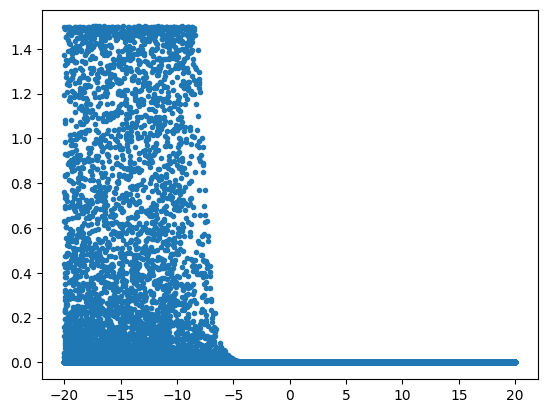

In [ ]:

plt.plot(txy_init[:,1:2],u_phi,'.')

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function1(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]


In [ ]:

backbone = create_dense_model_Normalized([12, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:
history = pinn.fit_custom(inputs, outputs, epochs = 30000, print_every = 500)



Epoch 0, Loss Residual: 0.0000061231, Loss Initial: 0.0821805447, Loss Boundary: 0.0755042806, Loss Boundary Y: 0.1392387152, MAE: 0.2281053513
Epoch 500, Loss Residual: 0.0005036198, Loss Initial: 0.0000841354, Loss Boundary: 0.0000871557, Loss Boundary Y: 0.0001330348, MAE: 0.0071813720
Epoch 1000, Loss Residual: 0.0001020087, Loss Initial: 0.0000071361, Loss Boundary: 0.0000131152, Loss Boundary Y: 0.0000195122, MAE: 0.0041033491
Epoch 1500, Loss Residual: 0.0000438527, Loss Initial: 0.0000031999, Loss Boundary: 0.0000073433, Loss Boundary Y: 0.0000101446, MAE: 0.0033778674
Epoch 2000, Loss Residual: 0.0000274533, Loss Initial: 0.0000020464, Loss Boundary: 0.0000052030, Loss Boundary Y: 0.0000069845, MAE: 0.0029816644
Epoch 2500, Loss Residual: 0.0000203433, Loss Initial: 0.0000015260, Loss Boundary: 0.0000040656, Loss Boundary Y: 0.0000053939, MAE: 0.0027141417
Epoch 3000, Loss Residual: 0.0000162378, Loss Initial: 0.0000012246, Loss Boundary: 0.0000033388, Loss Boundary Y: 0.00000

In [ ]:
history2 = {k: Test_hist[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary', 'loss_boundary_y')}

Text(0, 0.5, 'MAE')

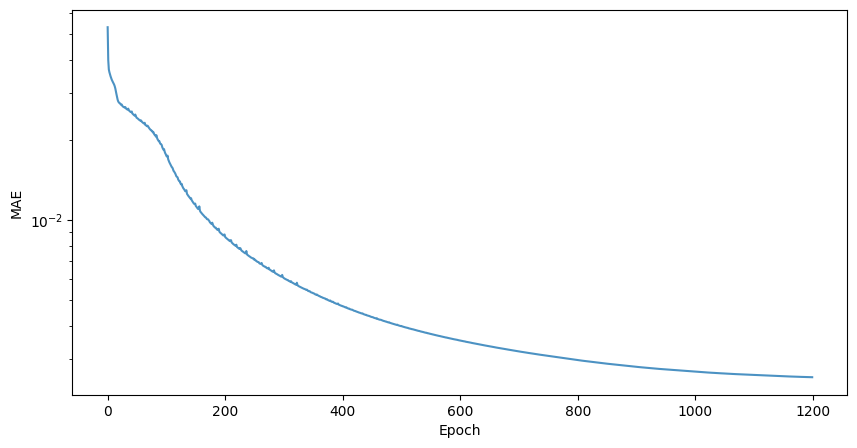

In [ ]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(Test_hist['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')


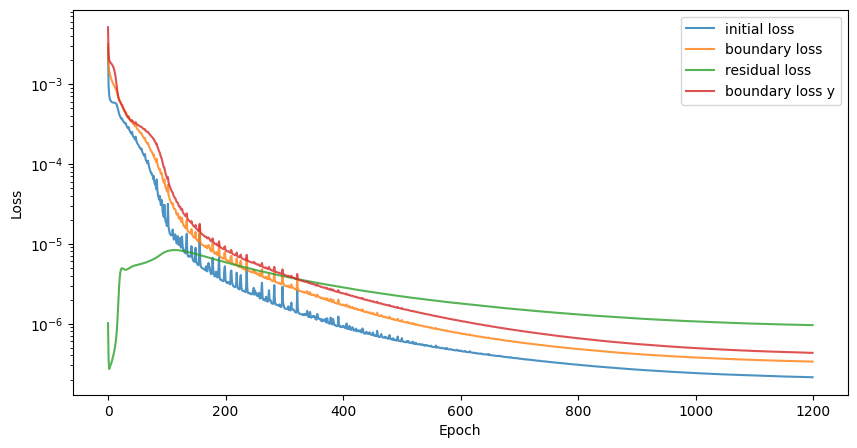

In [ ]:
plot_training_loss(history2, y_scale='log')

In [ ]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 200, phi_function = None, cross_sect = 0):

    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(y_start, ylength, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        x, y = np.meshgrid(x_flat, y_flat)
        txy = np.stack([np.full(x.flatten().shape, t_cs), x.flatten(), y.flatten()],axis=-1)


        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])

        u = pinn.backbone.predict(txy, batch_size=num_test_samples)
        u = u.reshape(x.shape)
        plt.pcolormesh(x, y, u)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(x,y,t)')
        cbar.mappable.set_clim(0., 0.3)
        # plt.savefig(str(os.getcwdb())[2:-1]+"/PDFsKPIISingleSoliton/Frame"+str(t_cs)+".pdf", format="pdf", bbox_inches="tight")
        fig = plt.figure()
        txy2 = np.stack([np.full(t_flat.shape, t_cs),  x_flat , np.full(t_flat.shape, cross_sect)], axis=-1)


        u2 = pinn.backbone.predict(txy2, batch_size=num_test_samples)
        uexact = phi_function(txy2)
        plt.plot(x_flat, u2, label = 'Prediction at time {}'.format(t_cs))
        plt.plot(x_flat, uexact, '.',label = 'Exact at time {}'.format(t_cs))
        plt.xlabel('x')
        plt.ylabel('u(x,y,t)')
        plt.legend()
        plt.title('wave cross section at y = {}'.format(cross_sect))

    return u2, x_flat


 80/200 [===========>..................] - ETA: 0s

<ipython-input-29-41dfae3f5bec>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7,4))


1/1 [==============================] - 0s 17ms/step


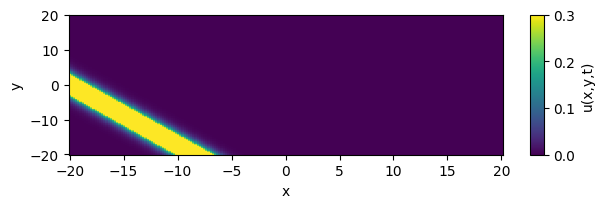

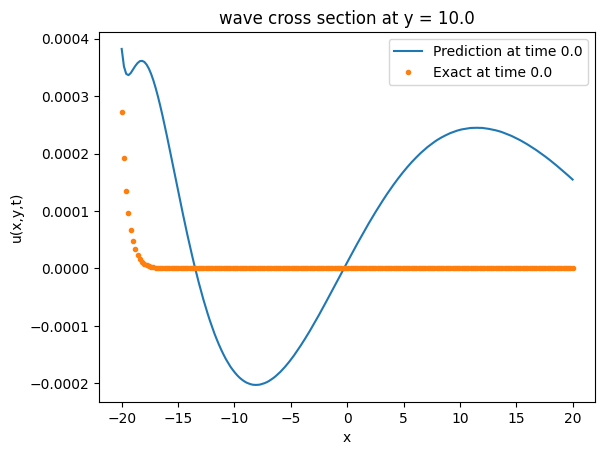

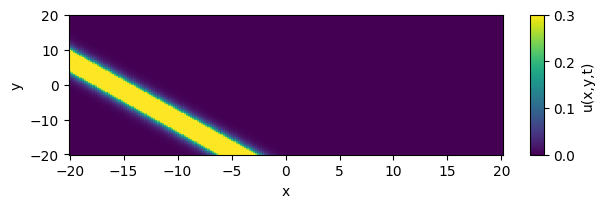

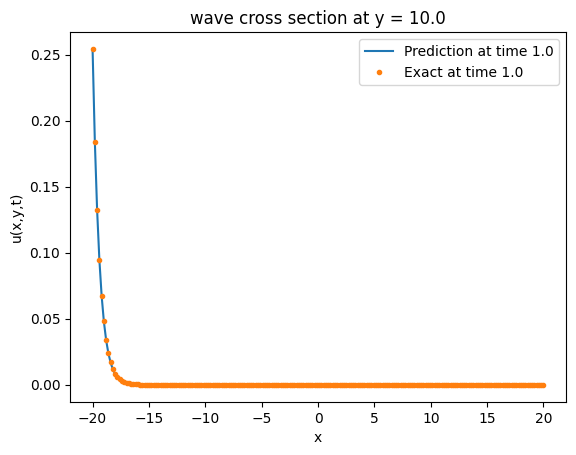

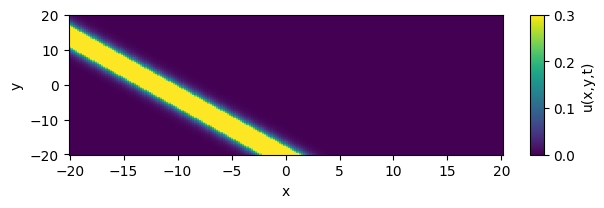

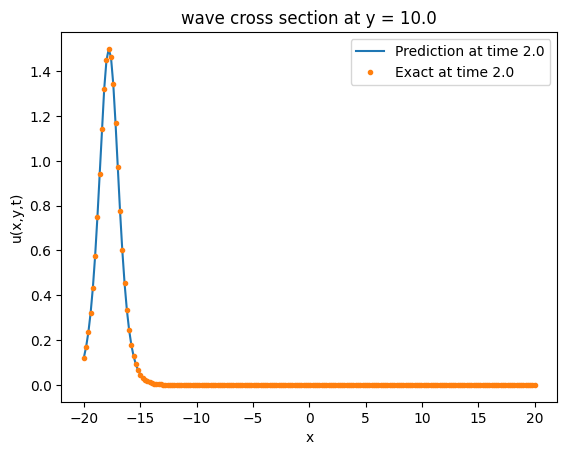

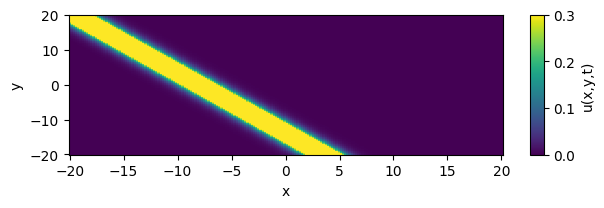

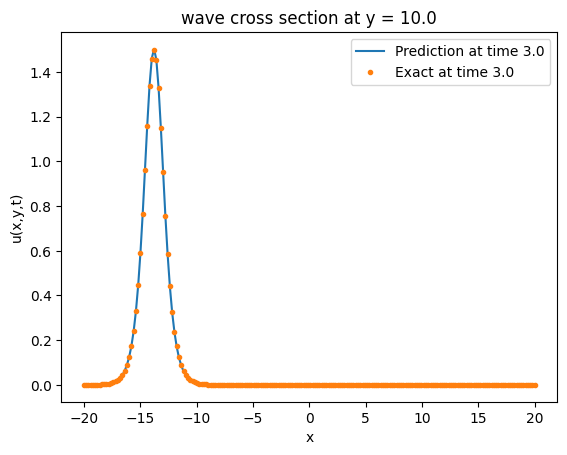

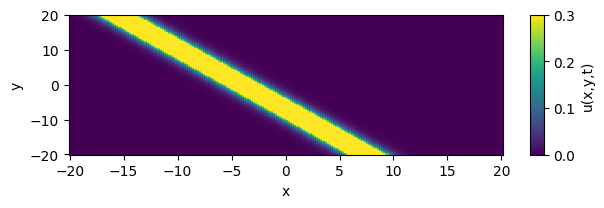

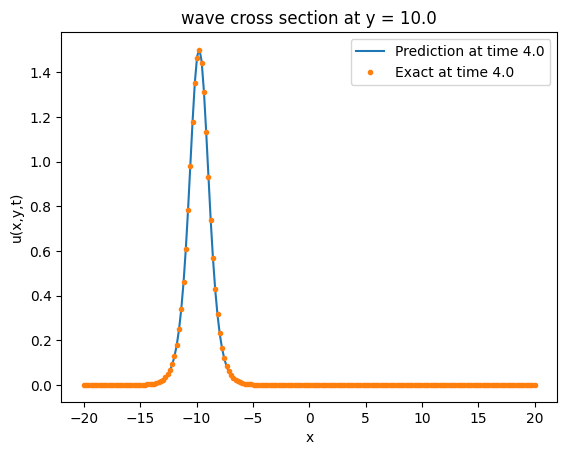

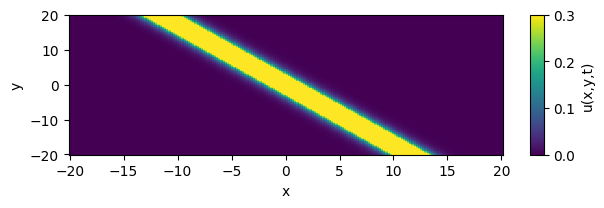

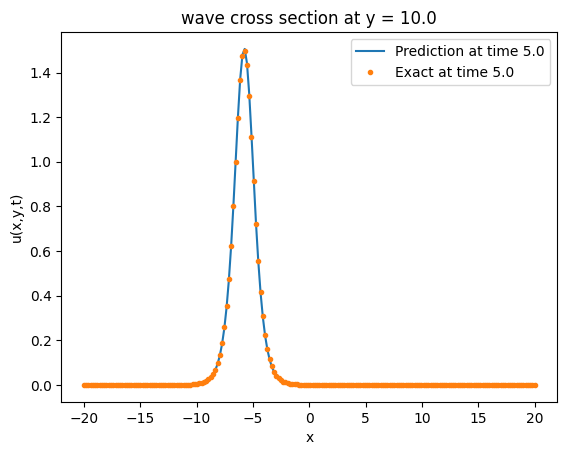

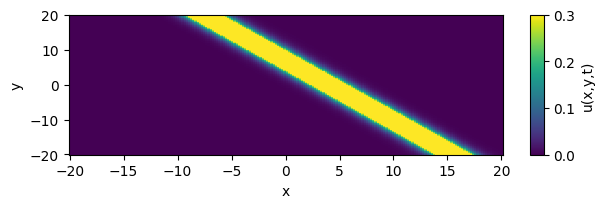

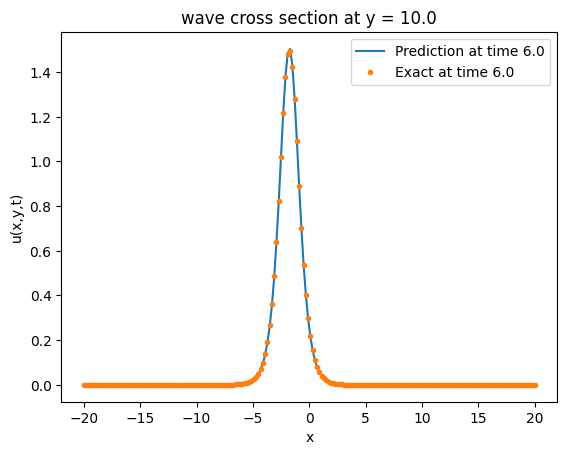

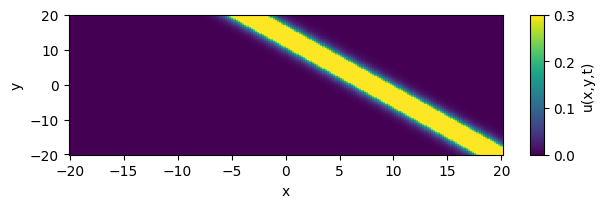

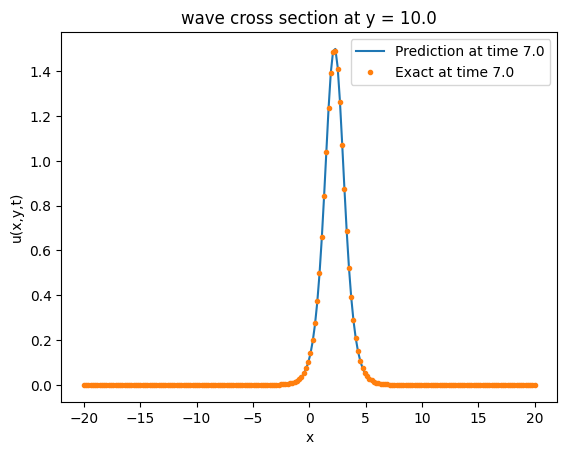

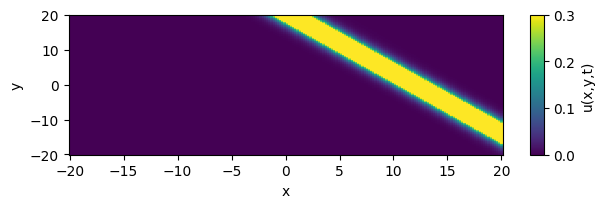

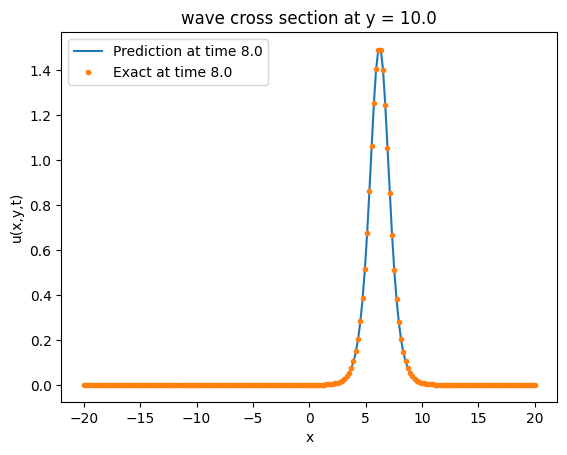

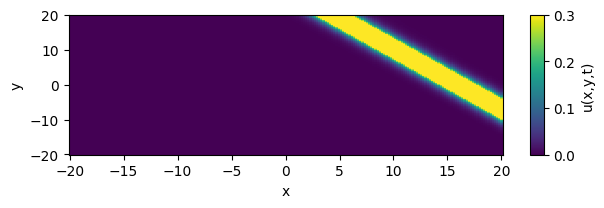

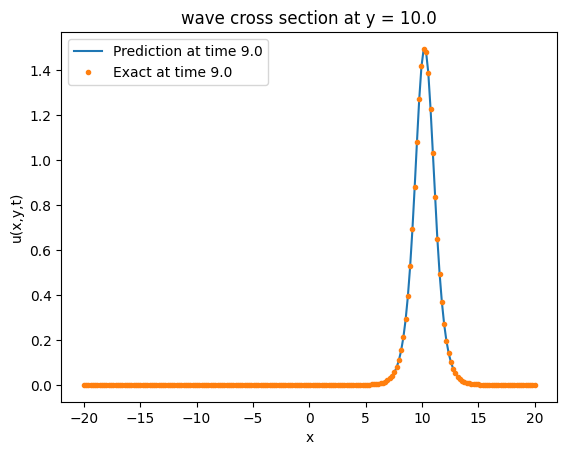

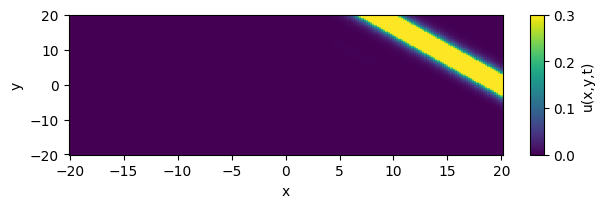

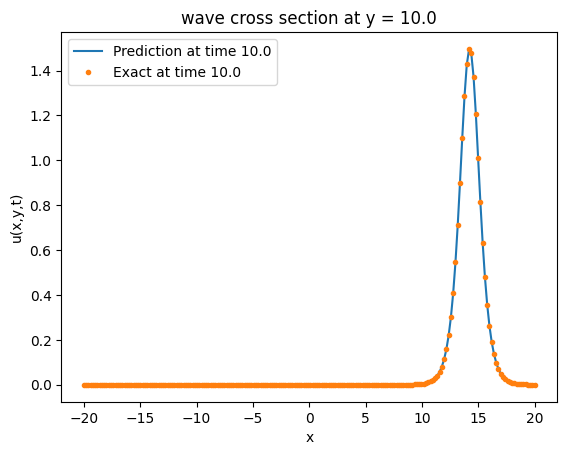

In [ ]:

u2pinn, xpinn = plot_snapshots(np.arange(0,time+1.,1), phi_function = phi_function1, cross_sect = 10.)